In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


# Create the Data

In [2]:
n_samples = 50000
omega = 2*np.pi # angular frequency
seq_len = 50 # points per sequence
d_t = .5 # sequence duration
t = np.linspace(0, d_t, seq_len)
X = []
y = []
for i in range(n_samples):
    phi = np.random.rand()*2*np.pi
    X.append(np.sin(t*omega+phi))
    y.append(np.sin((2*t[-1]-t[-2])*omega+phi))
X = np.array(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = np.array(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Build the Model

In [26]:
?LSTM

In [45]:
def build_model(batchsize, layers):
    model = Sequential()

    model.add(
        LSTM(
            units=layers[2],
            #input_shape=(1, 1, layers[0]),
            input_dim=layers[0],
            #output_dim=layers[1],
            #return_sequences=True)
        )
    )
    model.add(Dropout(0.2))

    #model.add(LSTM(
    #    layers[2],
    #    return_sequences=False))
    #model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [46]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, 
    ## in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [47]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [50]:
epochs  = 1
#seq_len = 50

print('> Compiling...')

batch_size=512
model = build_model(batch_size, [1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.05)

> Compiling...


/local/home/jostza/anaconda2/envs/modeling/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/local/home/jostza/anaconda2/envs/modeling/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, input_shape=(None, 1))`
  
/local/home/jostza/anaconda2/envs/modeling/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


('> Compilation Time : ', 0.03972005844116211)
Train on 33250 samples, validate on 1750 samples
Epoch 1/1
33250/33250 [==============================] - 28s - loss: 0.0314 - val_loss: 7.9142e-04


In [63]:
predicted = predict_point_by_point(model, X_test)
#predicted = predict_sequence_full(model, X_test, seq_len)

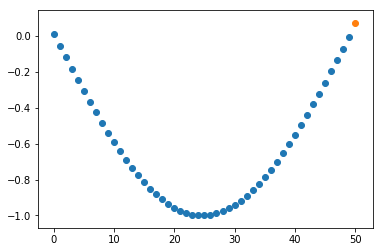

In [121]:
point_idx = 0 # the index of the test point you want to look at
plt.scatter(np.arange(X_test.shape[1]), list(X_test[point_idx,:,:].flatten()))
plt.scatter(x=[X_test.shape[1]], y=[predicted[point_idx]])

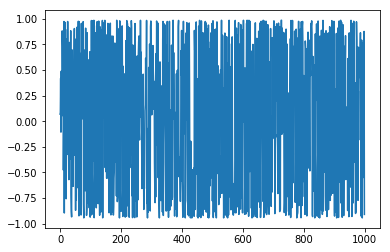

In [65]:
#plt.plot(predicted[:1000])

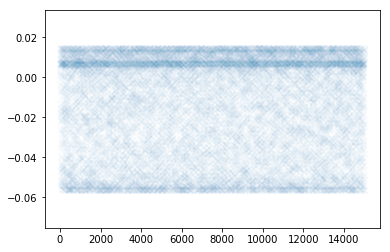

In [124]:
plt.scatter(np.arange(X_test.shape[0]), y_test-predicted, marker='x', alpha=.02)